In [1]:
import pyNUISANCE as pn
import pyProSelecta as pps
import pyNuHepMC as nhm

Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/t2kreweight-build/_deps/niwg-src/src/NIWG/Interface/NIWGEvent.h
   requested to autoload type niwg::NIWGParticle
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/t2kreweight-build/_deps/niwg-src/src/NIWG/Interface/NIWGEvent.h
   requested to autoload type niwg::NIWGEvent


Welcome to JupyROOT 6.30/04


In [2]:
evs = pn.EventSource("neutvect.t2kflux_numu_C_nofsi.root")
if not evs:
    print("Error: failed to open input file")

In [3]:
wf = pn.WeightCalcFactory()
t2krw = wf.make(evs, {"plugin_name":"T2KReWeight", "neut_cardname": "neut.t2kflux_numu_C_nofsi.card"})

In [4]:
import pprint

all_dials = []
for tgt in [ "C", ]:
    for nus in [ "nu", ]:
        for bi in range(3):
            all_dials.append("HFPW_toCRPAPWTwkDial_%s_%s_%s" % (tgt,nus,bi))
            all_dials.append("HFPW_toHFTwkDial_%s_%s_%s" % (tgt,nus,bi))

dial_tweaks = {}
for var in [1]:
    for di in all_dials:
        twk = {}
        for dj in all_dials:
            twk[dj] = var if di == dj else 0
        dial_tweaks["%s=%s" % (di,var)] = twk

dial_tweaks["SF_OptPotTwkDial_C12=1"] = {"SF_OptPotTwkDial_C12":1}

dial_tweaks["CV"] = {"HFPW_toCRPAPWTwkDial_C_nu_0":0,
                     "HFPW_toCRPAPWTwkDial_C_nu_1":0,
                     "HFPW_toCRPAPWTwkDial_C_nu_2":0,
                     "HFPW_toHFTwkDial_C_nu_0":0,
                     "HFPW_toHFTwkDial_C_nu_1":0,
                     "HFPW_toHFTwkDial_C_nu_2":0}

# pprint.pp(dial_tweaks)
colnames = [ x for x in dial_tweaks.keys() ]
pprint.pp(colnames)

['HFPW_toCRPAPWTwkDial_C_nu_0=1',
 'HFPW_toHFTwkDial_C_nu_0=1',
 'HFPW_toCRPAPWTwkDial_C_nu_1=1',
 'HFPW_toHFTwkDial_C_nu_1=1',
 'HFPW_toCRPAPWTwkDial_C_nu_2=1',
 'HFPW_toHFTwkDial_C_nu_2=1',
 'SF_OptPotTwkDial_C12=1',
 'CV']


In [5]:
def wghts(ev):
    resp = []
    for _,var in dial_tweaks.items():
        t2krw.set_parameters(var)
        resp.append(t2krw.calc_weight(ev))
    return resp

In [6]:
dir(pps.ext)

['Q2lep_GeV2',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'enu_GeV',
 'final_state_topology',
 'hm_ppi0_GeV',
 'hm_ppim_GeV',
 'hm_ppip_GeV',
 'hm_pprot_GeV',
 'hm_thetapi0_deg',
 'hm_thetapim_deg',
 'hm_thetapip_deg',
 'hm_thetaprot_deg',
 'isCC',
 'isCC0Pi',
 'isCC1Pi',
 'isCCMultiPi',
 'isNC0Pi',
 'isNC1Pi',
 'isNCMultiPi',
 'plep_GeV',
 'q0lep_GeV',
 'q3lep_GeV',
 'signal_process_id_filter',
 'thetalep_deg']

In [ ]:
from math import pi, cos

fg = pn.EventFrameGen(evs, 250000)\
  .filter(pps.ext.signal_process_id_filter(int(200))) \
  .add_column("enu", pps.ext.enu_GeV) \
  .add_column("q0", pps.ext.q0lep_GeV) \
  .add_column("q3", pps.ext.q3lep_GeV) \
  .add_column("Q2lep", pps.ext.Q2lep_GeV2) \
  .add_column("plep", pps.ext.plep_GeV) \
  .add_column("cthetalep", lambda ev: cos(pps.ext.thetalep_deg(ev * pi/180.0))) \
  .add_columns(colnames, wghts)
print(fg.firstArrow(int(20)))

In [8]:
chunk = fg.firstArrow(int(1E6))

NCCQE = 407323, NTotal = 1000000


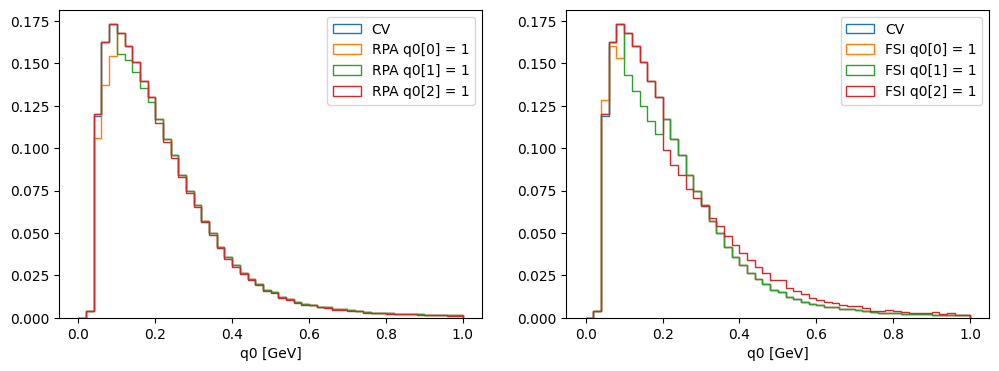

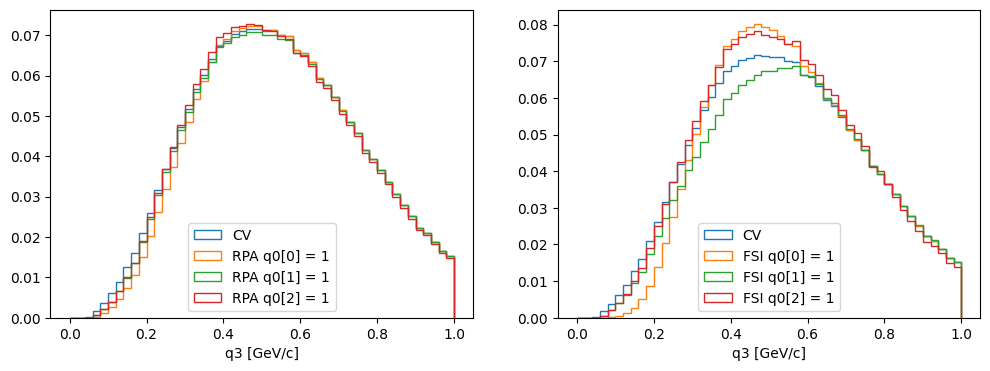

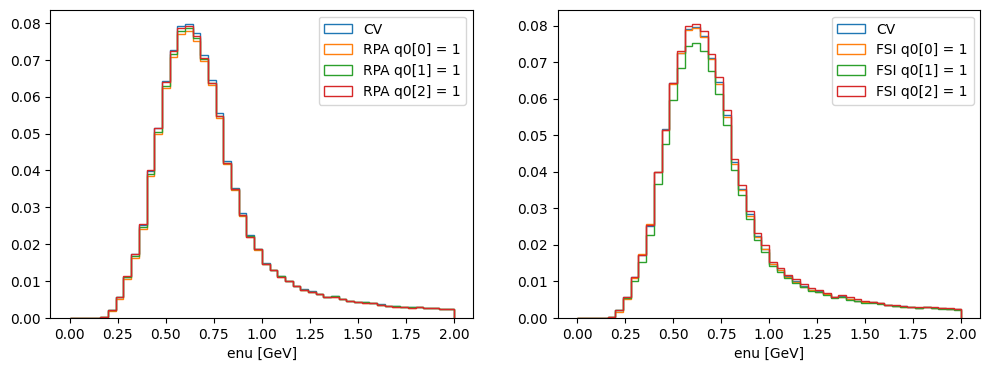

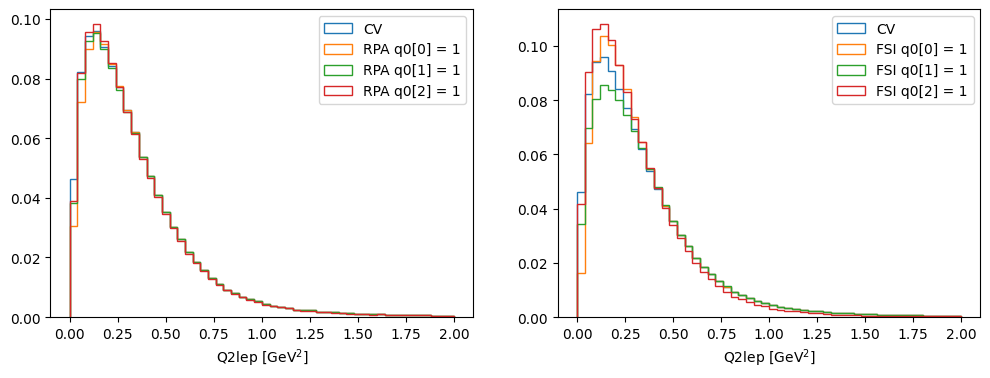

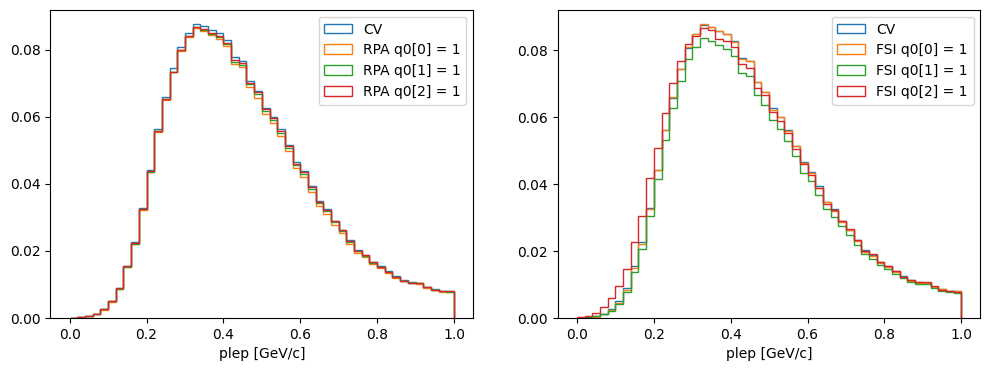

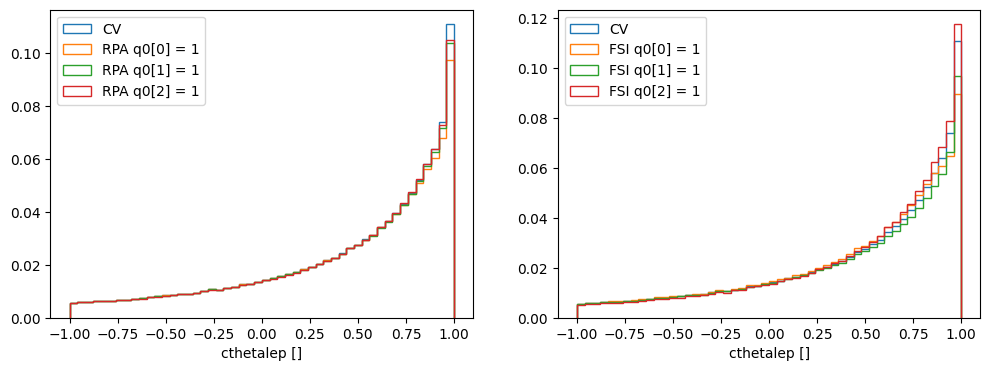

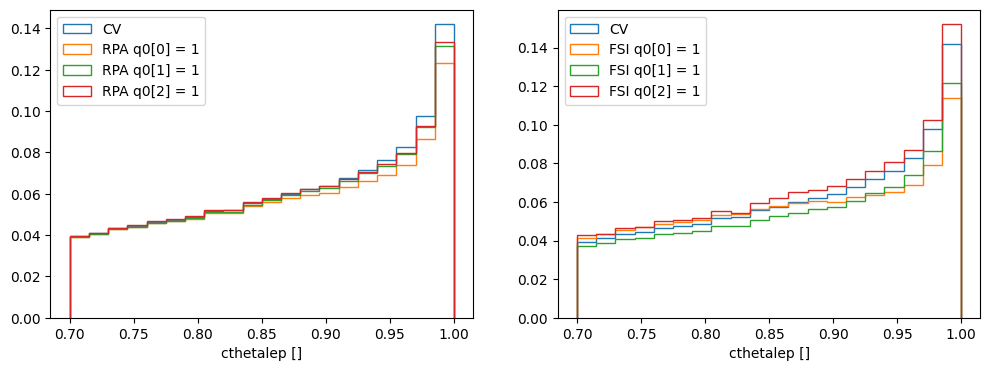

In [9]:
import numpy as np
import matplotlib.pyplot as plt

print("NCCQE = %s, NTotal = %s" %(chunk.num_rows, fg.norm_info().nevents))

plots = [
    ("q0","GeV", (0,1,50)),
    ("q3","GeV/c", (0,1,50)),
    ("enu","GeV", (0,2,50)),
    ("Q2lep",r"$\text{GeV}^{2}$", (0,2,50)),
    ("plep","GeV/c", (0,1,50)),
    ("cthetalep","", (-1,1,50)),
    ("cthetalep","", (0.7,1,20)),
]
for prj,unit,bins in plots:
    kin_hist = pn.HistFrame(pn.Binning.lin_space(*bins))
    kin_hist.fill_weighted_columns_from_Arrow(chunk,[prj],
                                              [ "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                                "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                                "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                                "HFPW_toHFTwkDial_C_nu_0=1",
                                                "HFPW_toHFTwkDial_C_nu_1=1",
                                                "HFPW_toHFTwkDial_C_nu_2=1"], ["CV", "weight.cv"])
    # scale to diff xs in pb/A
    kin_hist.sumweights = (kin_hist.sumweights / kin_hist.binning.bin_sizes()[:,np.newaxis]) * fg.norm_info().fatx_per_sumweights()
    
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    
    kin_hist.mpl().hist_all(columns=["mc",
        "HFPW_toCRPAPWTwkDial_C_nu_0=1","HFPW_toCRPAPWTwkDial_C_nu_1=1","HFPW_toCRPAPWTwkDial_C_nu_2=1"],
        labels=["CV", "RPA q0[0] = 1", "RPA q0[1] = 1", "RPA q0[2] = 1"],
        histtype='step', plot_axis=axes[0])
    
    axes[0].set_xlabel("%s [%s]" % (prj,unit))
    axes[0].legend()

    kin_hist.mpl().hist_all(columns=["mc",
        "HFPW_toHFTwkDial_C_nu_0=1","HFPW_toHFTwkDial_C_nu_1=1","HFPW_toHFTwkDial_C_nu_2=1"],
        labels=["CV", "FSI q0[0] = 1", "FSI q0[1] = 1", "FSI q0[2] = 1"],
        histtype='step', plot_axis=axes[1])
    
    axes[1].set_xlabel("%s [%s]" % (prj,unit))
    axes[1].legend()
    
    fig.show()

/tmp/ipykernel_8517/3586164996.py:17: RuntimeWarning: invalid value encountered in divide
  stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,i+1],q0q3h.sumweights[:,0])


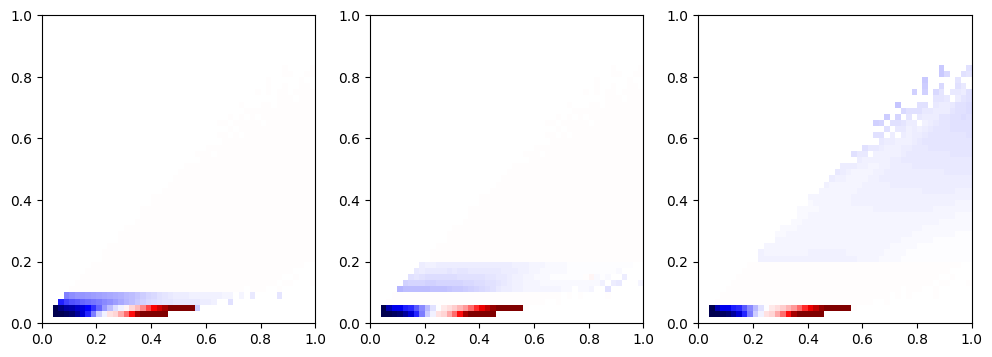

In [10]:
from copy import copy
import matplotlib as mpl

q0q3h = pn.HistFrame(pn.Binning.lin_spaceND([[0,1,50],[0,1,50]]))
q0q3h.fill_weighted_columns_from_Arrow(chunk,["q3","q0"],
                                          [ "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                            "HFPW_toHFTwkDial_C_nu_0=1",
                                            "HFPW_toHFTwkDial_C_nu_1=1",
                                            "HFPW_toHFTwkDial_C_nu_2=1"], ["CV", "weight.cv"])

fig, axes = plt.subplots(1,3, figsize=(12,4))
for i,ax in enumerate(axes):
    q0q3h_rpa0 = copy(q0q3h)
    stupid_eigennumpy = q0q3h_rpa0.sumweights.copy()
    stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,i+1],q0q3h.sumweights[:,0])
    q0q3h_rpa0.sumweights = stupid_eigennumpy
    q0q3h_rpa0.mpl().colormesh(plot_axis=ax,vmin=0,vmax=2, cmap=mpl.colormaps["seismic"])
fig.show()

/tmp/ipykernel_8517/3757170171.py:14: RuntimeWarning: invalid value encountered in divide
  stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,i+1],q0q3h.sumweights[:,0])


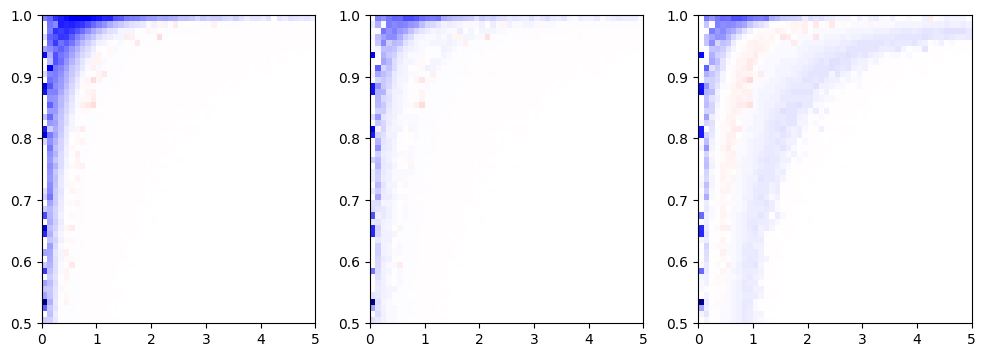

In [11]:
q0q3h = pn.HistFrame(pn.Binning.lin_spaceND([[0,5,50],[0.5,1,50]]))
q0q3h.fill_weighted_columns_from_Arrow(chunk,["plep","cthetalep"],
                                          [ "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                            "HFPW_toHFTwkDial_C_nu_0=1",
                                            "HFPW_toHFTwkDial_C_nu_1=1",
                                            "HFPW_toHFTwkDial_C_nu_2=1"], ["CV", "weight.cv"])

fig, axes = plt.subplots(1,3, figsize=(12,4))
for i,ax in enumerate(axes):
    q0q3h_rpa0 = copy(q0q3h)
    stupid_eigennumpy = q0q3h_rpa0.sumweights.copy()
    stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,i+1],q0q3h.sumweights[:,0])
    q0q3h_rpa0.sumweights = stupid_eigennumpy
    q0q3h_rpa0.mpl().colormesh(plot_axis=ax,vmin=0,vmax=2, cmap=mpl.colormaps["seismic"])
fig.show()

/tmp/ipykernel_8517/1558886927.py:5: RuntimeWarning: invalid value encountered in divide
  stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,i+4],q0q3h.sumweights[:,0])


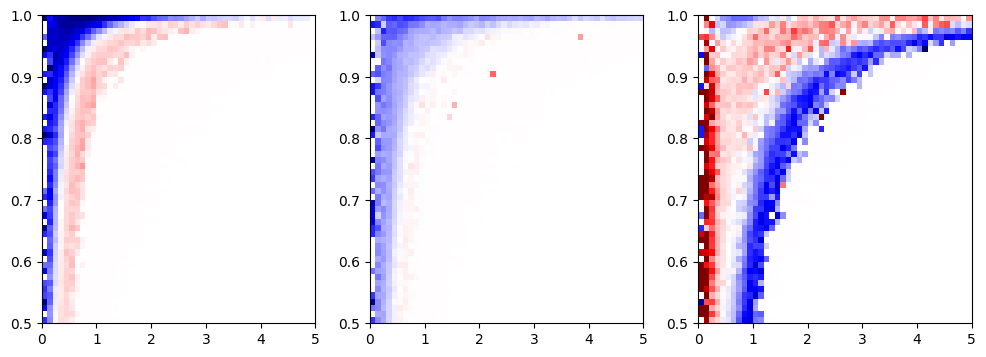

In [12]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
for i,ax in enumerate(axes):
    q0q3h_rpa0 = copy(q0q3h)
    stupid_eigennumpy = q0q3h_rpa0.sumweights.copy()
    stupid_eigennumpy[:,0] = np.divide(q0q3h.sumweights[:,i+4],q0q3h.sumweights[:,0])
    q0q3h_rpa0.sumweights = stupid_eigennumpy
    q0q3h_rpa0.mpl().colormesh(plot_axis=ax,vmin=0,vmax=2, cmap=mpl.colormaps["seismic"])
fig.show()

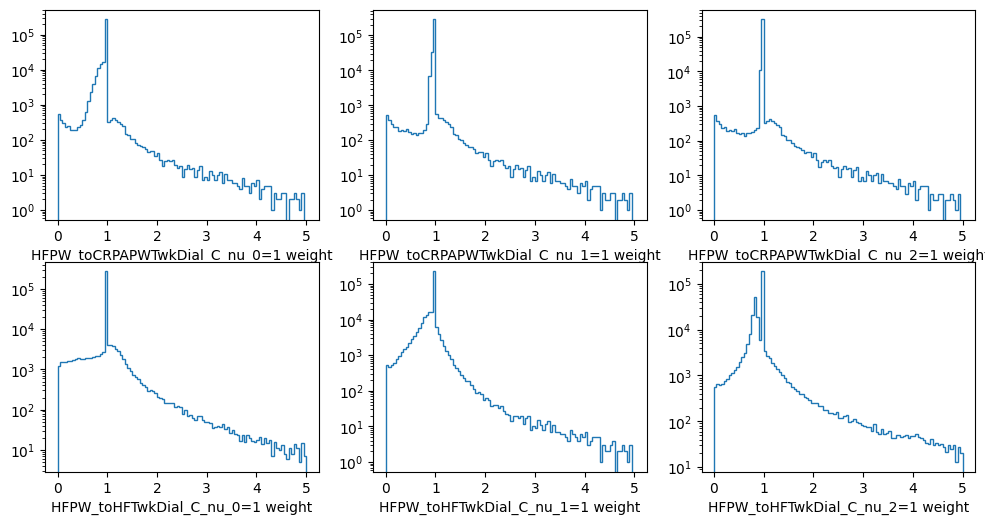

In [21]:
fig, axes = plt.subplots(2,3, figsize=(12,6))

for i,d in enumerate([ "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                        "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                        "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                        "HFPW_toHFTwkDial_C_nu_0=1",
                        "HFPW_toHFTwkDial_C_nu_1=1",
                        "HFPW_toHFTwkDial_C_nu_2=1"]):
    ax = axes[i//3,i%3]
    weightd = pn.HistFrame(pn.Binning.lin_space(1E-8,5,100))
    weightd.fill_weighted_columns_from_Arrow(chunk,[d],[])
    weightd.mpl().hist(histtype="step",plot_axis=ax)
    ax.set_xlabel("%s weight" % d)
    ax.set_yscale('log')
fig.show()